In [60]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from Scripts.dirty_accuracy import injection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN

## Helper functions

Gaussian Classification implementation

In [61]:
def GaussianClassification(X_train, y_train, X_test, y_test):
    clf = GaussianProcessClassifier()
    clf.fit(X_train, y_train)
    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    return [training_score, test_score]

K-Neighbors Classification implementation

In [62]:
def KNClassification(X_train, y_train, X_test, y_test):
    K = []
    training = []
    test = []
    scores = {}

    for k in range(1, 20):
        clf = KNeighborsClassifier(n_neighbors = k)
        clf.fit(X_train, y_train)

        training_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        K.append(k)

        training.append(training_score)
        test.append(test_score)
        scores[k] = [training_score, test_score]
    return [training[test.index(np.max(test))],np.max(test)]

Print scores

In [63]:
def printScores(scores):
    for score in scores:
        print("Dataset dirty at: ", score['dirty'], "%")
        print(score['scores'][0],':', score['scores'][1])

Z-Score detection and correction

In [64]:
def ZScore(data, threshold):
    if threshold == 0.6:    #the dataset is the clean one
        threshold = 1.5
    mean = np.mean(data)
    sd = np.std(data)
    cleaned = []
    for i in data:
        z = (i - mean) / sd
        if abs(z) > threshold:
            cleaned.append(mean)
        else:
            cleaned.append(i)
    return cleaned

DBSCAN detection and correction

In [65]:
def DBSCANDetectionColumn(data, col):
    dbs = DBSCAN(eps = 0.1)
    dbs.fit_predict(data)
    data = data.drop("temp", axis = 1)
    correct = data[dbs.labels_ != -1]
    mu = correct[col].mean()
    data.loc[dbs.labels_ == -1, col] = mu
    return data[col]

In [66]:
def DBSCANDetection(data):
    data["temp"] = 0
    columns = ["temp"]
    c = data.columns
    for col in c:
        if col != "temp":
            columns.append(col)
            data[col] = DBSCANDetectionColumn(data[columns], col)
    data = data.drop('temp', axis=1)
    return data

## Pipeline implementation

Read the dataset from CSV file
Drop the ID column

In [67]:
ecoli = pd.read_csv("datasets/ecoli.csv", sep=',')
ecoli = ecoli.drop('1', axis=1)

Perform the injections of outliers
and append the original clean dataset to the list

In [68]:
ecoli_list = injection(df_pandas=ecoli, seed=10, name='ecoli', name_class='class')
ecoli_list.append(ecoli)

saved ecoli-accuracy50%
saved ecoli-accuracy60%
saved ecoli-accuracy70%
saved ecoli-accuracy80%
saved ecoli-accuracy90%


Reverse the list on order to have
0 - Original Dataset
1 - 10% Dirty dataset
2 - 20% Dirty dataset
3 - 30% Dirty dataset
4 - 40% Dirty dataset
5 - 50% Dirty dataset

In [69]:
ecoli_list.reverse()

### Functions to be repeated for each dataframe

In [70]:
def computeScoresKN(dataframe_array):
    y = ecoli['class']
    scores = []
    i = 0
    for df in dataframe_array:
        X = df.drop('class', axis=1, errors='ignore')
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        sc = KNClassification(X_train, y_train, X_test, y_test)
        scores.append({'dirty': i, 'scores': sc})
        i = i + 10
    return scores

In [71]:
def computeScoresGC(dataframe_array):
    y = ecoli['class']
    scores = []
    i = 0
    for df in dataframe_array:
        X = df.drop('class', axis=1, errors='ignore')
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        sc = GaussianClassification(X_train, y_train, X_test, y_test)
        scores.append({'dirty': i, 'scores': sc})
        i = i + 10
    return scores

In [72]:
def cleanDatasetsZScore(datasets):
    cleaned_list = []
    i = 6
    for df in datasets:
        cleaned = df.copy()
        for col in cleaned.columns:
            if col == 'class':
                continue
            cleaned[col] = ZScore(cleaned[col].values, i/10)
        cleaned_list.append(cleaned)
        i = i-1
    return cleaned_list

In [73]:
def cleanDatasetDBSCAN(datasets):
    cleaned_list = []
    for df in datasets:
        cleaned = df.copy()
        cleaned = cleaned.drop('class', axis=1)
        cleaned = DBSCANDetection(cleaned)
        cleaned_list.append(cleaned)
    return cleaned_list

Compute scores

In [74]:
knscores = computeScoresKN(ecoli_list)
printScores(knscores)

Dataset dirty at:  0 %
0.8638297872340426 : 0.8613861386138614
Dataset dirty at:  10 %
0.6893617021276596 : 0.6633663366336634
Dataset dirty at:  20 %
0.5276595744680851 : 0.5346534653465347
Dataset dirty at:  30 %
0.5191489361702127 : 0.45544554455445546
Dataset dirty at:  40 %
0.39574468085106385 : 0.40594059405940597
Dataset dirty at:  50 %
0.46808510638297873 : 0.48514851485148514


In [75]:
gcscore = computeScoresGC(ecoli_list)
printScores(gcscore)

Dataset dirty at:  0 %
0.7659574468085106 : 0.7227722772277227
Dataset dirty at:  10 %
0.8127659574468085 : 0.504950495049505
Dataset dirty at:  20 %
0.9276595744680851 : 0.40594059405940597
Dataset dirty at:  30 %
0.9361702127659575 : 0.3564356435643564
Dataset dirty at:  40 %
0.9829787234042553 : 0.27722772277227725
Dataset dirty at:  50 %
0.9957446808510638 : 0.36633663366336633


Find column by column outliers using ZScore and DBSCAN and replace them with mean value

In [76]:
cleaned_zs_lists = cleanDatasetsZScore(ecoli_list)
cleaned_dbs_list = cleanDatasetDBSCAN(ecoli_list)

Perform again the classification after outliers detection and print results

In [77]:
cleaned_knscores_zs = computeScoresKN(cleaned_zs_lists)
cleaned_gcscores_zs = computeScoresGC(cleaned_zs_lists)
cleaned_knscores_dbs = computeScoresKN(cleaned_dbs_list)
cleaned_gcscores_dbs = computeScoresGC(cleaned_dbs_list)

In [78]:
printScores(cleaned_knscores_zs)

Dataset dirty at:  0 %
0.8085106382978723 : 0.6831683168316832
Dataset dirty at:  10 %
0.8127659574468085 : 0.8217821782178217
Dataset dirty at:  20 %
0.8425531914893617 : 0.7821782178217822
Dataset dirty at:  30 %
0.7106382978723405 : 0.7524752475247525
Dataset dirty at:  40 %
0.7872340425531915 : 0.6732673267326733
Dataset dirty at:  50 %
0.6468085106382979 : 0.6237623762376238


In [79]:
printScores(cleaned_gcscores_zs)

Dataset dirty at:  0 %
0.7063829787234043 : 0.6534653465346535
Dataset dirty at:  10 %
0.6978723404255319 : 0.6831683168316832
Dataset dirty at:  20 %
0.6936170212765957 : 0.6633663366336634
Dataset dirty at:  30 %
0.6 : 0.6039603960396039
Dataset dirty at:  40 %
0.5957446808510638 : 0.5841584158415841
Dataset dirty at:  50 %
0.5276595744680851 : 0.5742574257425742


In [80]:
printScores(cleaned_knscores_dbs)

Dataset dirty at:  0 %
0.774468085106383 : 0.7326732673267327
Dataset dirty at:  10 %
0.825531914893617 : 0.7227722772277227
Dataset dirty at:  20 %
1.0 : 0.6237623762376238
Dataset dirty at:  30 %
0.7787234042553192 : 0.7029702970297029
Dataset dirty at:  40 %
0.6510638297872341 : 0.6039603960396039
Dataset dirty at:  50 %
0.6893617021276596 : 0.6039603960396039


In [81]:
printScores(cleaned_gcscores_dbs)

Dataset dirty at:  0 %
0.6723404255319149 : 0.6435643564356436
Dataset dirty at:  10 %
0.6382978723404256 : 0.6138613861386139
Dataset dirty at:  20 %
0.5914893617021276 : 0.594059405940594
Dataset dirty at:  30 %
0.5872340425531914 : 0.594059405940594
Dataset dirty at:  40 %
0.5531914893617021 : 0.5544554455445545
Dataset dirty at:  50 %
0.49361702127659574 : 0.5346534653465347


### Plot data preparation

Transform the score object array into an array of test scores

In [82]:
def toArray(score):
    t = []
    for s in score:
        t.append(s['scores'][1])
    return t

Preparation of plot DataFrame

In [83]:
plotData = {
    'dirty': [0, 10, 20, 30, 40, 50],
    'knc_pre': toArray(knscores),
    'gc_pre': toArray(gcscore),
    'knc_zs_post': toArray(cleaned_knscores_zs),
    'gc_zs_post': toArray(cleaned_gcscores_zs),
    'knc_dbs_post': toArray(cleaned_knscores_dbs),
    'gc_dbs_post': toArray(cleaned_gcscores_dbs)
}
plotDF = pd.DataFrame(plotData)

#### Comparison between pre and post detection scores for each combination of algorithms

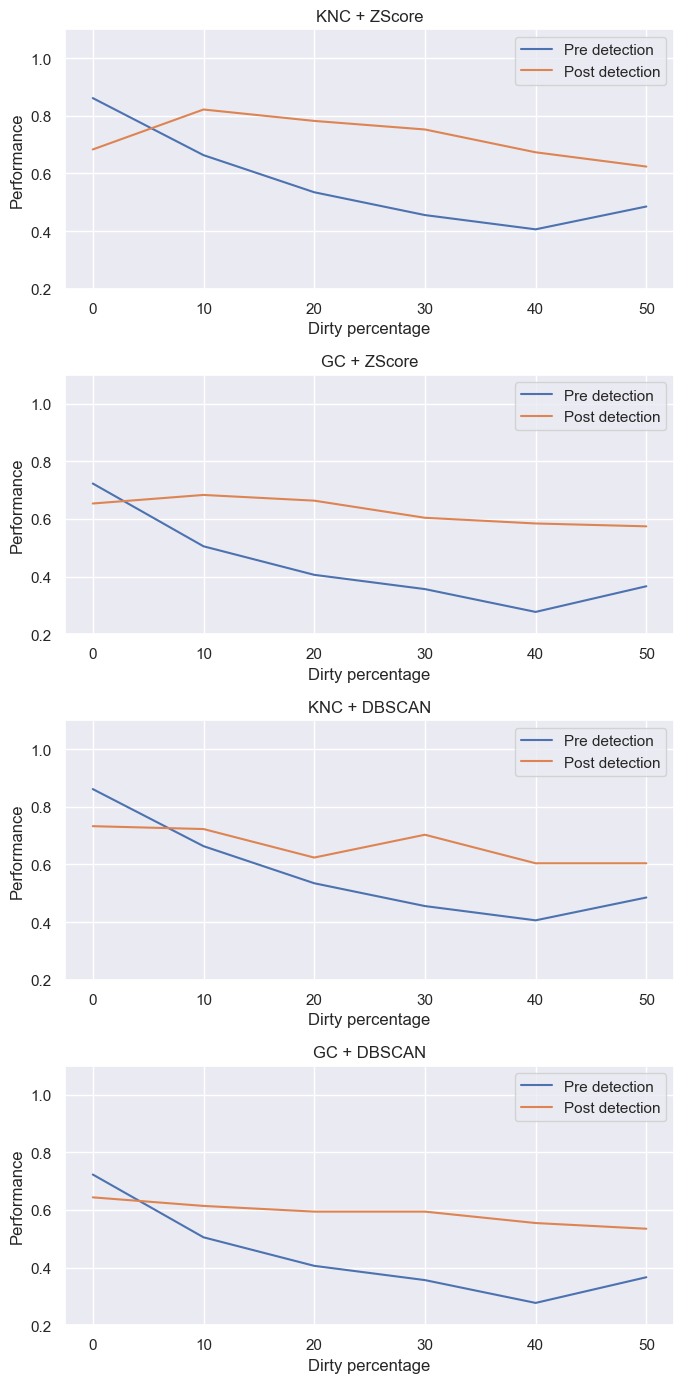

In [84]:
sns.set()
fig, axes = plt.subplots(4, 1, sharex=False, figsize=(7,14))

sns.lineplot(ax=axes[0], x='dirty', y='knc_pre', data=plotDF)
sns.lineplot(ax=axes[0], x='dirty', y='knc_zs_post', data=plotDF)
axes[0].legend(['Pre detection', 'Post detection'])
axes[0].set(xlabel='Dirty percentage', ylabel='Performance')
axes[0].set_ylim(0.2,1.1)
axes[0].set_title('KNC + ZScore')

sns.lineplot(ax=axes[1], x='dirty', y='gc_pre', data=plotDF)
sns.lineplot(ax=axes[1], x='dirty', y='gc_zs_post', data=plotDF)
axes[1].legend(['Pre detection', 'Post detection'])
axes[1].set(xlabel='Dirty percentage', ylabel='Performance')
axes[1].set_ylim(0.2,1.1)
axes[1].set_title('GC + ZScore')

sns.lineplot(ax=axes[2], x='dirty', y='knc_pre', data=plotDF)
sns.lineplot(ax=axes[2], x='dirty', y='knc_dbs_post', data=plotDF)
axes[2].legend(['Pre detection', 'Post detection'])
axes[2].set(xlabel='Dirty percentage', ylabel='Performance')
axes[2].set_ylim(0.2,1.1)
axes[2].set_title('KNC + DBSCAN')

sns.lineplot(ax=axes[3], x='dirty', y='gc_pre', data=plotDF)
sns.lineplot(ax=axes[3], x='dirty', y='gc_dbs_post', data=plotDF)
axes[3].legend(['Pre detection', 'Post detection'])
axes[3].set(xlabel='Dirty percentage', ylabel='Performance')
axes[3].set_ylim(0.2,1.1)
axes[3].set_title('GC + DBSCAN')
fig.tight_layout()

#### Comparison between the two classification algorithms pre-detection and post-detection (for each outlier detection algorithm)

Text(0.5, 1.0, 'Post detection DBSCAN performances')

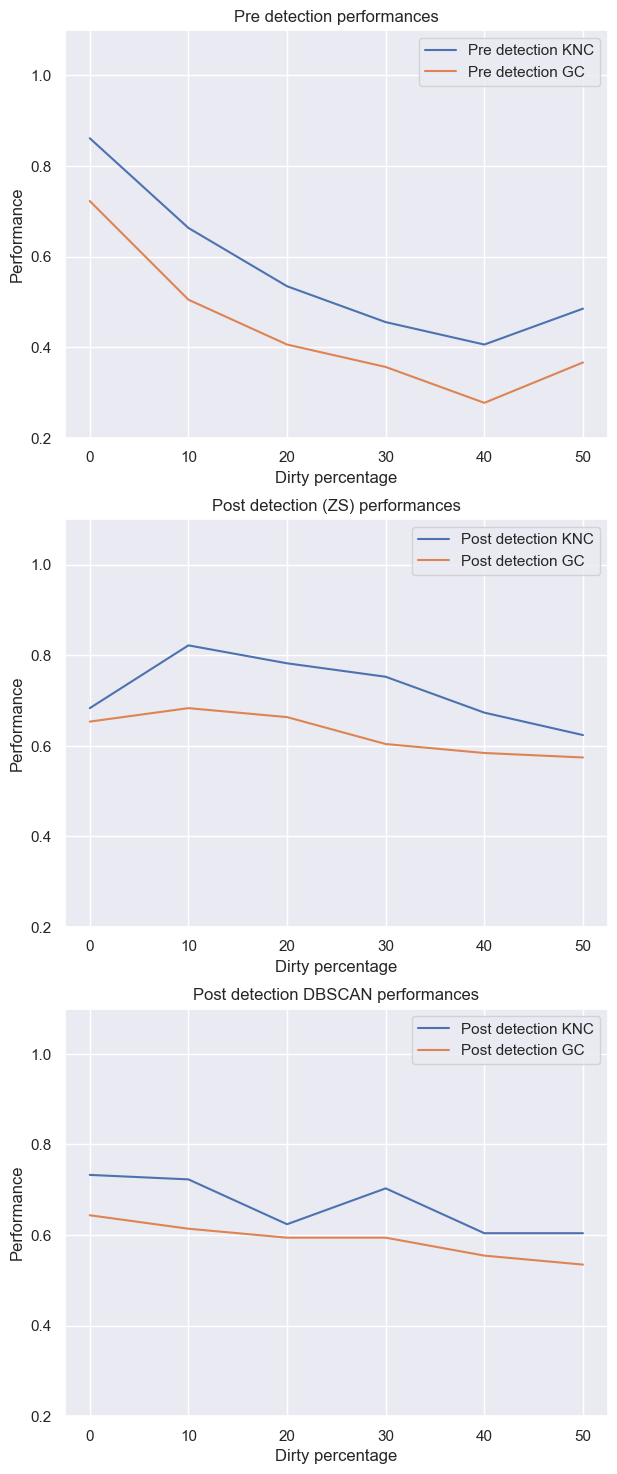

In [85]:
sns.set()
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(7,18))

sns.lineplot(ax=axes[0], x='dirty', y='knc_pre', data=plotDF)
sns.lineplot(ax=axes[0], x='dirty', y='gc_pre', data=plotDF)
axes[0].legend(['Pre detection KNC', 'Pre detection GC'])
axes[0].set(xlabel='Dirty percentage', ylabel='Performance')
axes[0].set_ylim(0.2,1.1)
axes[0].set_title('Pre detection performances')

sns.lineplot(ax=axes[1], x='dirty', y='knc_zs_post', data=plotDF)
sns.lineplot(ax=axes[1], x='dirty', y='gc_zs_post', data=plotDF)
axes[1].legend(['Post detection KNC', 'Post detection GC'])
axes[1].set(xlabel='Dirty percentage', ylabel='Performance')
axes[1].set_ylim(0.2,1.1)
axes[1].set_title('Post detection (ZS) performances')

sns.lineplot(ax=axes[2], x='dirty', y='knc_dbs_post', data=plotDF)
sns.lineplot(ax=axes[2], x='dirty', y='gc_dbs_post', data=plotDF)
axes[2].legend(['Post detection KNC', 'Post detection GC'])
axes[2].set(xlabel='Dirty percentage', ylabel='Performance')
axes[2].set_ylim(0.2,1.1)
axes[2].set_title('Post detection DBSCAN performances')

#### Comparison between detection algorithms for each post-detection one

Text(0.5, 1.0, 'GC Post-detection performances')

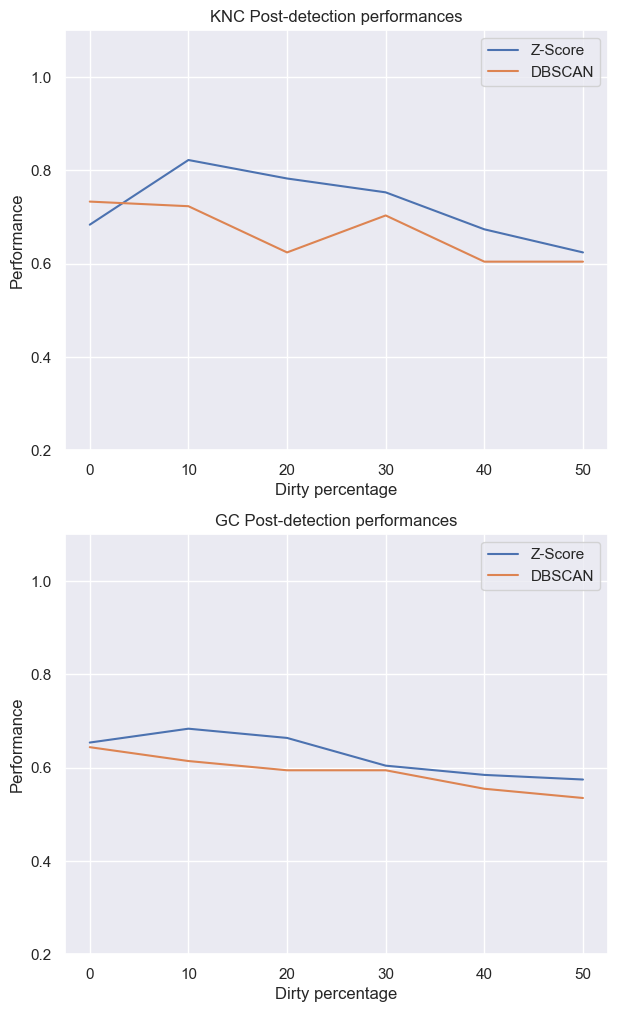

In [86]:
sns.set()
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(7,12))

sns.lineplot(ax=axes[0], x='dirty', y='knc_zs_post', data=plotDF)
sns.lineplot(ax=axes[0], x='dirty', y='knc_dbs_post', data=plotDF)
axes[0].legend(['Z-Score', 'DBSCAN'])
axes[0].set(xlabel='Dirty percentage', ylabel='Performance')
axes[0].set_ylim(0.2,1.1)
axes[0].set_title('KNC Post-detection performances')

sns.lineplot(ax=axes[1], x='dirty', y='gc_zs_post', data=plotDF)
sns.lineplot(ax=axes[1], x='dirty', y='gc_dbs_post', data=plotDF)
axes[1].legend(['Z-Score', 'DBSCAN'])
axes[1].set(xlabel='Dirty percentage', ylabel='Performance')
axes[1].set_ylim(0.2,1.1)
axes[1].set_title('GC Post-detection performances')